# Das Vier-Quadranten-Diagramm

Im Folgenden wird versucht, die einzelnen Elemente des Vier-Quadranten-Diagramms näher zu erklären.
Im Diagramm werden Informationen zu Zugkraft und Widerständen (Quadrant I), Übersetzung/Getriebe (Quadrant II und IV) sowie Motormoment und Verbrauch (Quadrant III) dargestellt.

_**Hinweis**: Zum Ausführen von Code-Elementen klicke Sie in das Code-Feld und drücken **"Enter+Shift"**
Zuerst den ersten Codeblock ausführen (% matplotlib notebook ...) . Die restlichen Blocks funktionieren unabhängig von einander. Je nach Serverauslastung dauert die Erzeugung/das Update einzelner Plots etwas._

In [1]:
%matplotlib notebook
from graphics_module import *

<IPython.core.display.Javascript object>


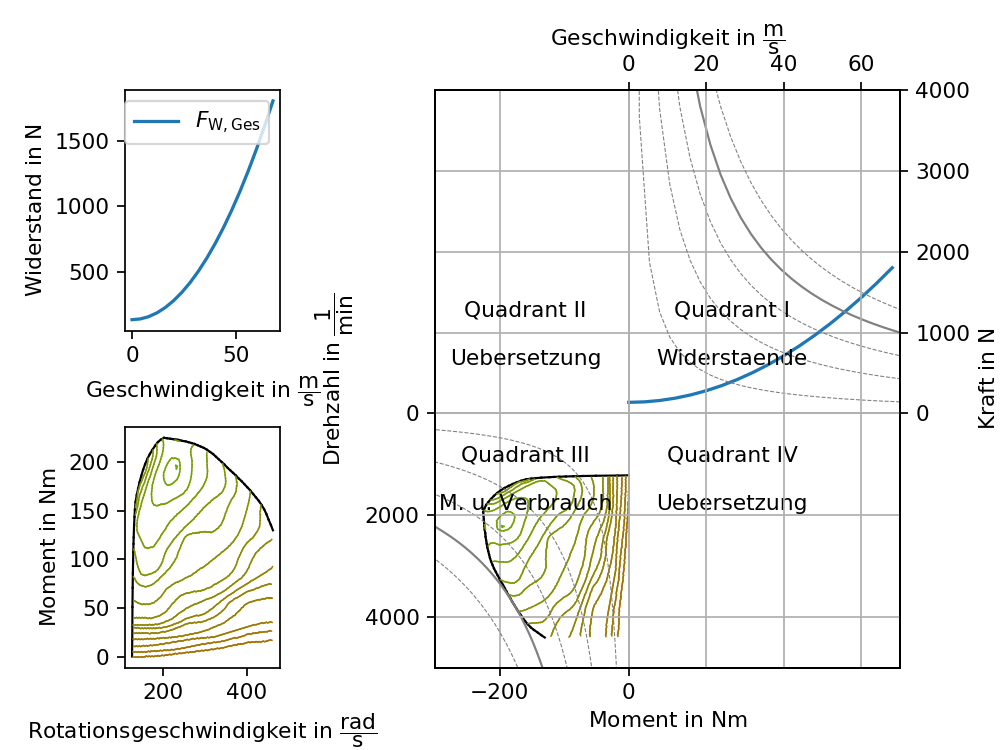

In [2]:
quadrants_plot()

## Quadrant I: Zugkraft und Fahrwiderstände

Die Widerstände berechnen sich wie folgt:

Radwiderstand:

$F_\mathrm{W,R}=f_\mathrm{r} \cdot m \cdot g$

Steigungswiderstand:

$F_\mathrm{W,St} = \sin(\alpha) \cdot m \cdot g \approx \alpha \cdot m \cdot g$

Luftwiderstand:

$F_\mathrm{W,L}=\dfrac{1}{2}c_\mathrm{w} \cdot A \cdot \rho_{\mathrm{L}} \cdot v_\mathrm{rel}^2$

Beschleunigungswiderstand:

$F_\mathrm{W,Be}= m \cdot a$

Im Diagramm nicht dargestellt ist der Anhängerwiderstand.

$F_\mathrm{W,Ges} = F_\mathrm{W,R} + F_\mathrm{W,St} + F_\mathrm{W,L} + F_\mathrm{W,Be}$

Die Widerstandsleistung ist:

$P_\mathrm{W,i} = F_\mathrm{W,i} \cdot v$ (Zum Beispiel: $P_\mathrm{W,Ges} = F_\mathrm{W,Ges} \cdot v$)

_**Vergleiche Kapitel 1 Fahrwiderstände, Folien 23-33**_

<IPython.core.display.Javascript object>


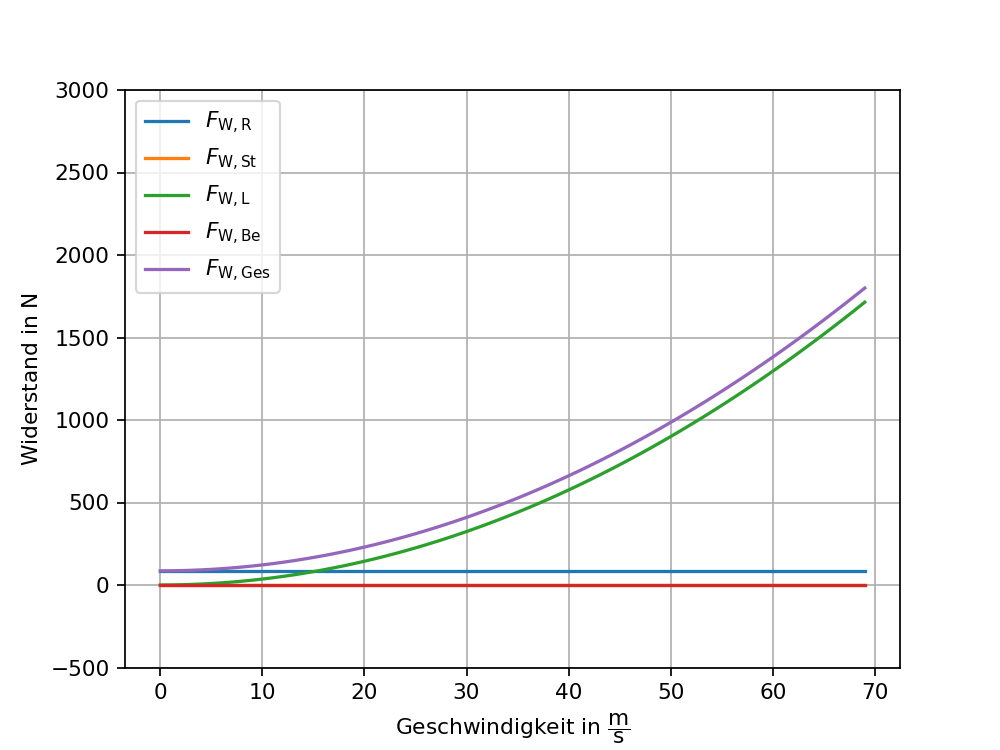

interactive(children=(FloatSlider(value=0.007, description='fr', max=0.015, step=0.001), IntSlider(value=1250,…

In [3]:
resistance_plot()

## Quadrant III: Motormoment und sowie Verbrauch

Im folgenden Diagramm ist das Motordrehmoment bzw. die Motorleistung über die Drehzahl aufgetragen.

_**Vergleiche Kapitel 3: Antrieb, Folie 30**_

Zusätzlich makieren die farbigen  Linien Punkte mit dem selben spezifischen
Kraftstoffverbrauchs $b_e$.

_**Vergleiche Kapitel 3: Antrieb, Folien 32-37**_

Für verschiedene Leistungen lassen sich Iso-Linien darstellen. Da $P=M\cdot \omega$ gilt, ergibt sich $M(\omega)=\dfrac{P_\mathrm{konst}}{\omega}$. Somit werden Punkte mit gleicher Leistung durch hyperförmige Linien gekennzeichnet.

_**Hinweis: Die Grafik ist an https://de.wikipedia.org/wiki/Verbrauchskennfeld angelehnt. (Mitsubishi Colt DI-D Dreizylinder-Dieselmotors mit 1,5 l Hubraum)**_

<IPython.core.display.Javascript object>


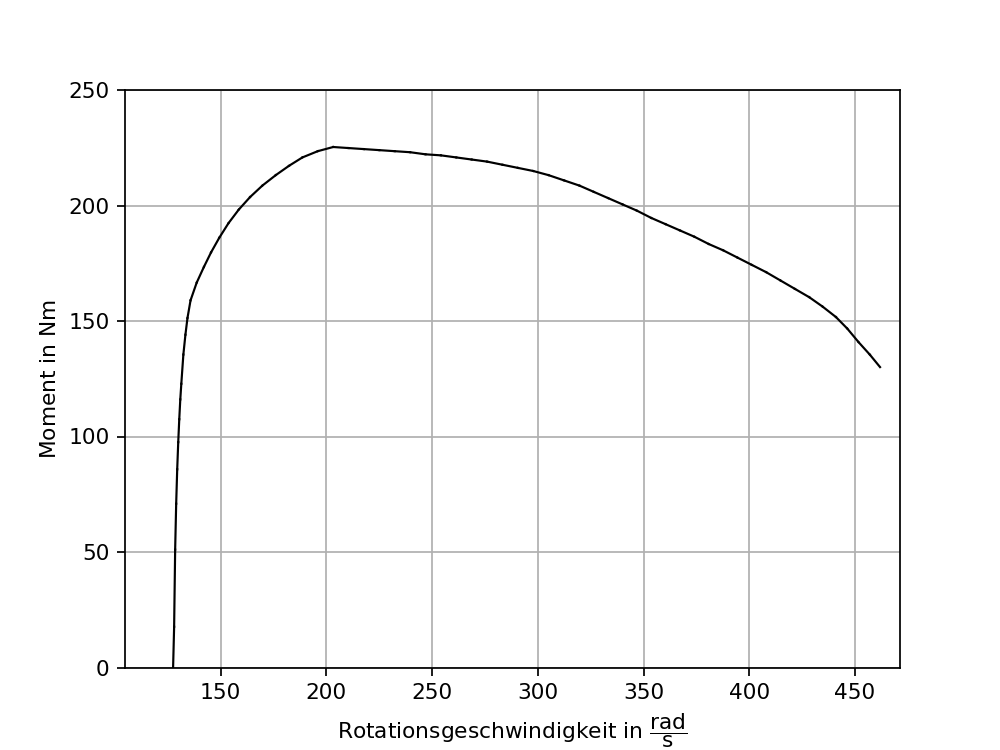

interactive(children=(Checkbox(value=False, description='Muscheldiagramm'), Checkbox(value=False, description=…

In [4]:
engine_plot()

Widerstände und Motorkennfeld werden in Quadrant I und III eingetragen. Quadrant II und IV geben die Übersetzung zwischen Drehmoment und Zugkraft (Quadrant II) und Winkelgeschwindigkeit/Drehzahl und Fahrgeschwindigkeit (Quadrant IV).

_** Hinweis: Achsenrichtung beachten: Motormoment nach links, Winkelgeschwindigkeit/Drehzahl nach unten.**_

<IPython.core.display.Javascript object>


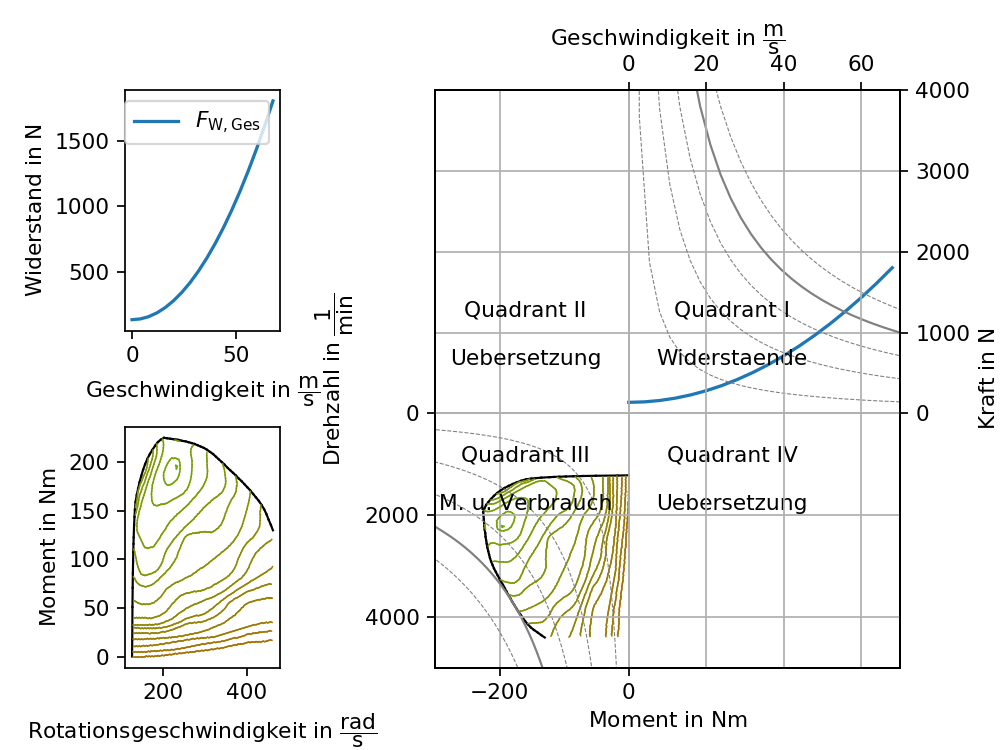

In [5]:
quadrants_plot()

Quadranten II und IV beschreiben die Übersetzung. Prinzipiell ergibt sich die Geschwindigkeit aus der Motordrehzahl wie folgt. (Bei schlupffreier Kupplung und auch keinen anderen Verlust im Antriebsstrang oder an den Reifen (zum Beispiel durch Schlupf).

$v=r_\mathrm{dyn}\cdot\omega_\mathrm{rad}=\underbrace{r_\mathrm{dyn}\cdot\dfrac{1}{i_\mathrm{a}\cdot i_\mathrm{g}}}_{\dfrac{1}{i_\mathrm{ges}}}\cdot \omega_\mathrm{M}$

Im Folgenden wird $\dfrac{i_\mathrm{a}\cdot i_\mathrm{g}}{r_\mathrm{dyn}}$ als $i_\mathrm{ges}$ mit Einheit $\frac{1}{\mathrm{m}}$ zusammengefasst. Ist $i_\mathrm{ges}$ konstant (zum Beispiel bei einem gewöhnlichen Getriebe) ist der Zusammenhang zwischen $v$ und $\omega$ sowie $F$ und $M$ linear. Bei gegebener Übersetzung kann also das durch den Widerstand am Motor erzeugte Moment und das vom Motor zur Verfügung stehenede Moment als Zugkraft im Diagramm dargestellt werden, indem Punkte jeweils an der Gerade gespiegelt werden. Dies entspricht der Division durch bzw. der Multiplikation mit $i_\mathrm{ges}$.

<IPython.core.display.Javascript object>


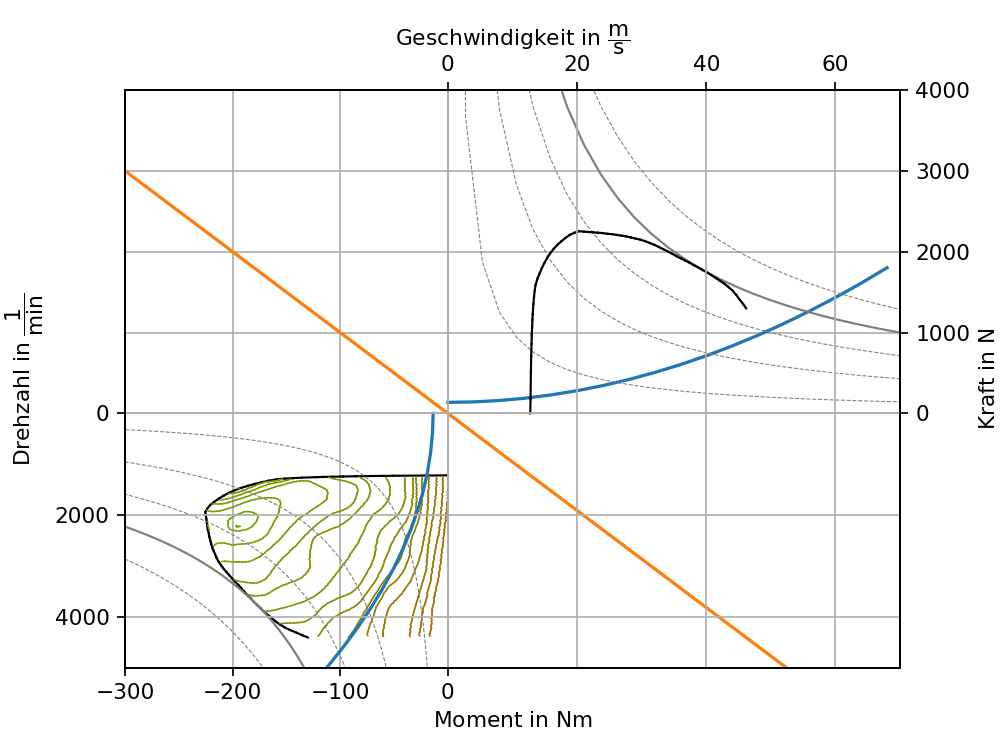

interactive(children=(FloatSlider(value=10.0, description='iges', max=20.0, min=1.0, step=0.5), Output()), _do…

In [6]:
transmission_plot()

Im folgenden Diagramm ist der Unterschied zwischern geometrischer Übersetzung zu sehen.

* Für die geometrische Übersetzung gilt:

    $\alpha_\mathrm{G}=\dfrac{i_{z-1}}{i_z}$
    
    Zum Beispiel: $i_4 = \alpha_\mathrm{G}\cdot i_5=1,3$ für $\alpha_\mathrm{G}=1$ und bei direkt fünften Gang
    ohne Übersetzung ($i_5=1$).
    
    
* Für die progressive Übersetzung gilt:

    ...to be continued...



<IPython.core.display.Javascript object>


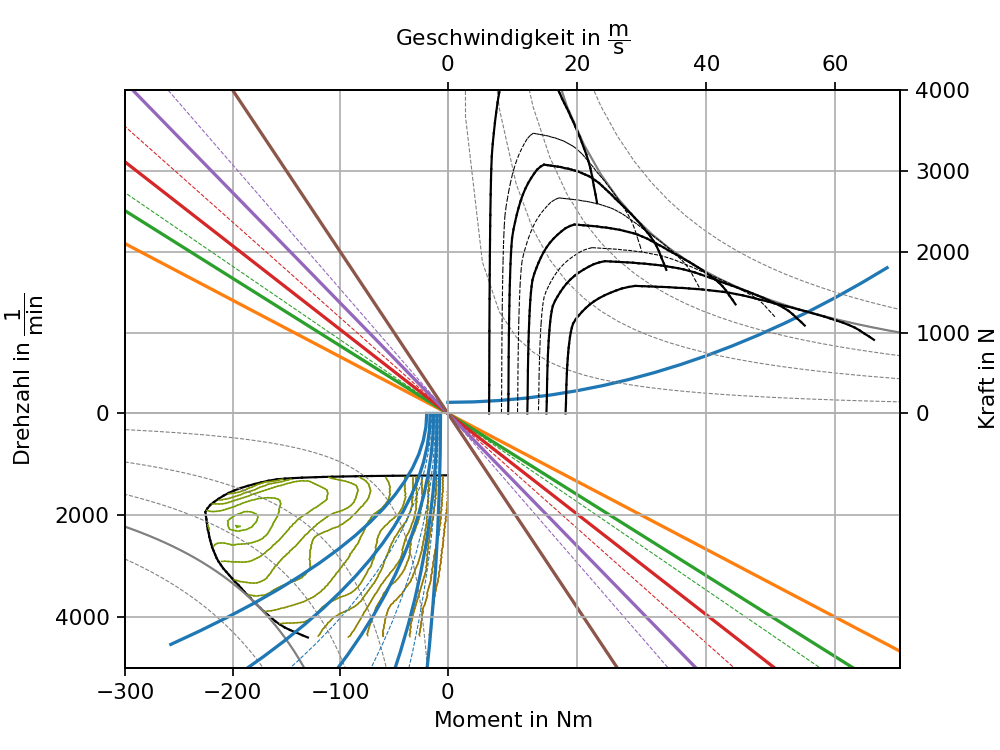

interactive(children=(Dropdown(description='Auslegung', options=('geometrisch', 'progressiv', 'beide'), value=…

In [7]:
multi_gear_plot()